# "Modulo 2"
> "Analisi della termodinamica di network random attraverso diagonalizzazione esatta dell'Hamiltoniana"

### $$ \hat{H} = -\sum_{i,j}^N J_{ij}\hat{\sigma}_i^z \hat{\sigma}_{j}^z - \sum_{i}^N g_i \hat{\sigma}_i^x - \sum_{i}^N h_i \hat{\sigma}_i^z$$ 

Il modello in esame rappresenta un sistema di $N$ spin-$\frac{1}{2}$ quantistici che interagiscono tra di loro in maniera casuale (statica). Può essere visto come la generalizzazione di un modello di Ising quantistico unidimensionale. È importante sottolineare come la topologia del sistema non sia importante, ma lo è considerare gli spin fissi e distinguibili, e dare un ordinamento ai singoli elementi del sistema in modo da poter rappresentare le loro interazioni attraverso una matrice di adiacenza. Infatti, una volta labellati gli elementi con un numero intero che va da 1 ad N, essi si possono considerare giacenti su una varietà unidimensionale, avendo però interazioni tra spin anche a lunga distanza.
Infatti la rappresentazione hamiltoniana di un sistema del genere differisce da quella di un modello di Ising quantistico 1D solamente per il fatto che la somma su $i$ e $j$ non è ristretta ai primi vicini, ma a tutti gli elementi del sistema e $J_{ij}$ è una matrice $N\times N$ generica. In questo senso il modello può essere visto come una generalizzazione del modello di Ising, in quanto esistono matrici di adiacenza $J_{ij}$, che rappresentano un reticolo unidimensionale, per cui il modello rappresentato **è** il modello di Ising, ma, attraverso altre matrici di adiacenza, si possono rappresentare per esempio modelli di Ising quantistici 2D oppure, come nel caso sotto esame, sistemi con interazioni casuali.

In [2]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss
from scipy.sparse import lil_matrix

### Modello di Ising 1D
Iniziamo dunque con l'implementazione dell'algoritmo che diagonalizza l'Hamiltoniana di un modello di Ising quantistico 1D con interazioni a primi vicini standard. 
#### $$ \hat{H} = -J\sum_{<i,j>}^N \hat{\sigma}_i^z \hat{\sigma}_{j}^z - g\sum_{i}^N \hat{\sigma}_i^x - h\sum_{i}^N  \hat{\sigma}_i^z$$ 

L'implementazione consiste in alcuni step:

1. Si costruisce la base con cui si rappresenterà l'Hamiltoniana

2. Si costruisce l'Hamiltoniana: 
   * Contributo delle interazioni a primi vicini
   * Implementazione delle condizioni al bordo periodiche
   * Contributo delle interazioni con un campo esterno longitudinale $h$
   * Contributo delle interazioni con un campo esterno trasversale $g$
   


3. Si trova l'autovalore minore e l'autovettore corrispondente (Ground State) attraverso una routine che implementa il metodo 

4. Si calcola la magnetizzazione associata al Ground State

5. Si calcola la suscettività magnetica e il calore specifico

In [2]:
#collapse
hh=0
volte=100
volte+=1

lins=np.linspace(0,2,volte)
linell=np.arange(3,8)*2-1
nell=linell.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))


ell1=0
for ell in linell:
    ggg=0
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        # Sigma_z Sigma_z [coupling]

        for iHam in range(ell-1):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==iSpin[ii,iHam+1]:
                    HamOut[ii,ii]=HamOut[ii,ii]-1
                else: HamOut[ii,ii]=HamOut[ii,ii]+1

        # This implements periodic boundary conditions
        if PBC:
            for ii in range(NumTot):
                if iSpin[ii,ell-1]==iSpin[ii,0]:
                    HamOut[ii,ii]=HamOut[ii,ii]-1
                else: HamOut[ii,ii]=HamOut[ii,ii]+1

        # Sigma_z  [longitudinal field]

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    HamOut[ii,ii]=HamOut[ii,ii]-hh
                else: HamOut[ii,ii]=HamOut[ii,ii]+hh

        # Sigma_x  [transverse field]

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagnetZ=0

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        ggg+=1
    ell1+=1
    
magniz1=magniz
Egs1=Egs
xi1=xi
ci1=ci
lins1=lins
linell1=linell

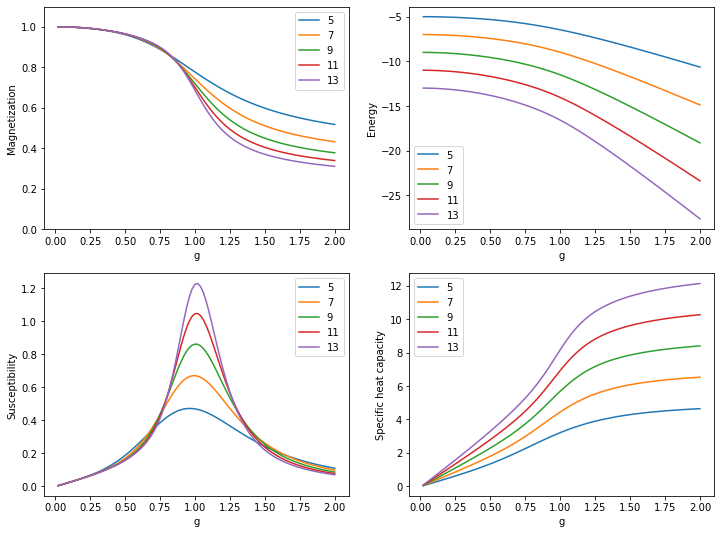

In [3]:
#collapse

plt.figure(figsize=(12, 9))

plt.subplot(221)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],magniz1[1:,i],label=elle)
plt.legend()
plt.ylim(0,1.1)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],Egs1[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],xi1[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],ci1[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    


plt.show()

Come possiamo notare la suscettività magnetica presenta un picco in corrispondenza di $g=1$ che all'aumentare della taglia del sistema diventa sempre più accentuato, ad indicare che nel limite termodinamico si osserva un punto critico ed il sistema presenta una transizione da una fase ferromagnetica ad una paramagnetica all'aumentare di $g$, effetto previsto dalla soluzione analitica del sistema.

Per studiare meglio questo effetto procediamo con uno studio del **Finite Size Scaling**.

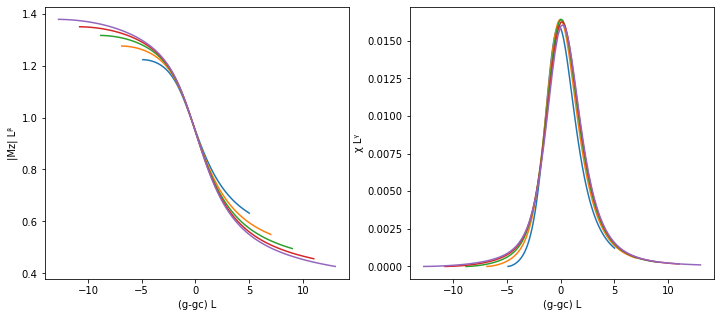

In [4]:
Fmagniz=np.zeros((volte,nell))
Fxi=np.zeros((volte+1,nell))
Flins=np.zeros((volte,nell))

ell1=0
for ell in linell:

    Fmagniz[:,ell1]=magniz1[:,ell1]*(ell)**(1/8)
    Fxi[:,ell1]=(xi1[:,ell1]/(ell))**(7/4)
    Flins[:,ell1]=(lins1-1)*(ell)
    
    ell1+=1


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Flins[1:],Fmagniz[1:])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('|Mz| Lᵝ')


plt.subplot(122)
plt.plot(Flins[1:],Fxi[1:volte])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('χ Lᵞ')


plt.show()

Il Finite Size Scaling è stato operato inserendo come esponenti critici quelli conosciuti tramite la risoluzione analitica del problema ovvero:
$$\beta=1/8, \quad \gamma=7/4, \quad   \nu=1, \quad    Y_g=1$$

avendo considerato il caso con campo esterno longitudinale $h=0$.

Poichè i grafici per le varie taglie del sistema coincidono quasi esattamente possiamo concludere che gli esponenti critici sono giusti e che quindi siamo in presenza di una transizione di fase relativa alla corretta classe di universalità.

## Implementazione della matrice di adiacenza

Al fine di poter calcolare le osservabili termodinamiche di un sistema con connessioni random è necessario implementare nell'algoritmo un modo per rappresentare le connessioni attraverso una matrice di adiacenza.

Per farlo andremo ad aggiungere uno step alla costruzione dell'Hamiltoniana in cui, data una matrice di adiacenza con alcuni elementi diversi da zero, andremo a controllare per ogni collegamento, se gli spin corrispondenti agli indici dell'elemento diverso da zero sono concordi o discordi ed andremo ad aggiungere o togliere energia alla configurazione considerata. 

La matrice di adiacenza essendo sparsa non verrà considerata tutta, ma solo gli elementi diversi da zero, per velocizzare la compilazione.

Per verificare il giusto comportamento del nuovo codice è stato testato usando come matrice di adiacenza proprio quella relativa ad un reticolo 1D intero con connessioni a primi vicini, per poi essere confrontato con i risultati precedenti che devono risultare uguali.

Introduciamo quindi una funzione che genera le matrici di adiacenza relative a reticoli d-dimensionali interi aventi L elementi per lato:

In [3]:
def AdD(d,L):
    # This function returns the sparse adjacency matrix of a d-dimensonal  
        # integer lattice with side L and the total number of elements N=L**d
    # Only for Periodic Boundary Conditions
    
    import scipy.sparse as ss
    N=L**d
    A=ss.dok_matrix((N,N))
    for i in range(N):
        for j in range(d):
            A[i,(i+L**j)%N] = 1
            A[i,(i-L**j)%N] = 1
    return A.copy().tocoo(), N

E testiamo quindi il funzionamento del codice aggiornato per implementare le matrici di adiacenza:

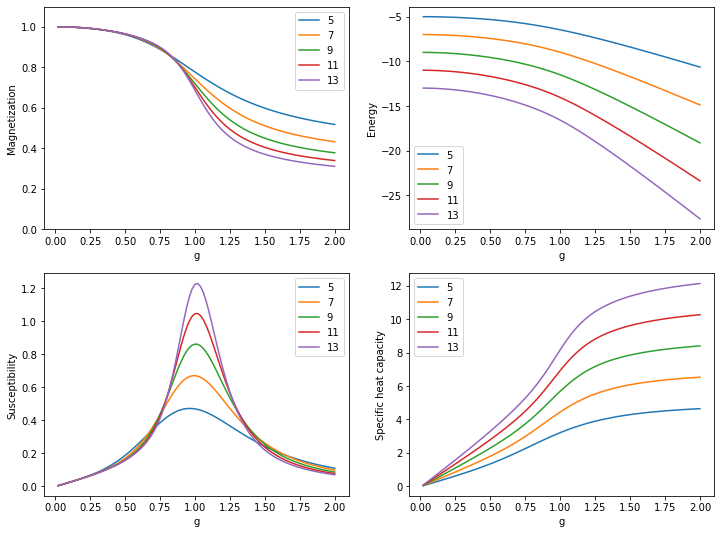

In [6]:
#collapse
hh=0
volte=100
volte+=1

lins=np.linspace(0,2,volte)
linell=np.arange(3,8)*2-1
nell=linell.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))

jay=-1/2


ell1=0
for ell in linell:
    ggg=0
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=AdD(1,ell)[0]      # Matrice di Adiacenza per un reticolo 1D
    coll=ss.find(net)
    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagX=np.zeros(ell)
        MagZ=np.zeros(ell)
        MagnetZ=0

        for iSite in range(ell):
            Mx_sum=0
            for ii in range(NumTot):
                if iSpin[ii,iSite] == 1:
                    MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                    Exc = ii -2**(iSite)
                else:
                    MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                    Exc = ii +2**(iSite)
                Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
            if abs(np.imag(Mx_sum))>10**(-10):
                print("Non real magnetization")
            MagX[iSite] = np.real(Mx_sum) 

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        
        ggg+=1
    ell1+=1


magniz2=magniz
Egs2=Egs
xi2=xi
ci2=ci
lins2=lins
linell2=linell

plt.figure(figsize=(12, 9))

plt.subplot(221)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],magniz1[1:,i],label=elle)
plt.legend()
plt.ylim(0,1.1)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],Egs1[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],xi1[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
for i in range(nell):
    elle=linell1[i]
    plt.plot(lins1[1:],ci1[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    


plt.show()

I grafici rislutano identici a quelli precedenti ed insieme al Finite Size Scaling sottostante, usando gli stessi esponenti critici, ci confermano il corretto funzionamento del codice.

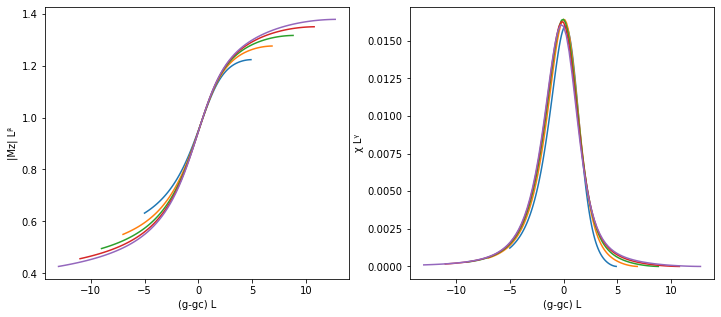

In [7]:
#collapse
Fmagniz=np.zeros((volte,nell))
Fxi=np.zeros((volte+1,nell))
Flins=np.zeros((volte,nell))

ell1=0
for ell in linell:

    Fmagniz[:,ell1]=magniz2[:,ell1]*(ell)**(1/8)
    Fxi[:,ell1]=(xi2[:,ell1]/(ell))**(7/4)
    Flins[:,ell1]=-(lins-1)*(ell)
    
    ell1+=1


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Flins[1:],Fmagniz[1:])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('|Mz| Lᵝ')


plt.subplot(122)
plt.plot(Flins[1:],Fxi[1:volte])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('χ Lᵞ')


plt.show()

### Modello di Ising 2D

Ora sfruttiamo questo stesso procedimento per studiare il modello di Ising quantistico 2D, usando la matrice di adiacenza opportuna, e confrontarlo con ***i risultati Monte-Carlo della relazione precedente per*** un modello Ising classico 3D, verificando il Quantum to Classical Mapping.

In [ ]:
#collapse

hh=0
volte=60
volte+=1

lins=np.linspace(0,6,volte)
linell=np.arange(2,5)
nell=linell.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
dm=np.zeros((volte+1,nell))
de=np.zeros((volte+1,nell))

jay=-1/2


ell1=0
for ell in linell:
    ggg=0
    
    net=AdD(2,ell)[0]
    coll=ss.find(net)
    
    ell=ell*ell
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    

    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot),dtype="float32"),dtype="float32")

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagX=np.zeros(ell)
        MagZ=np.zeros(ell)
        MagnetZ=0

        for iSite in range(ell):
            Mx_sum=0
            for ii in range(NumTot):
                if iSpin[ii,iSite] == 1:
                    MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                    Exc = ii -2**(iSite)
                else:
                    MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                    Exc = ii +2**(iSite)
                Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
            if abs(np.imag(Mx_sum))>10**(-10):
                print("Non real magnetization")
            MagX[iSite] = np.real(Mx_sum) 

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        dm[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        de[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        
        ggg+=1
    ell1+=1


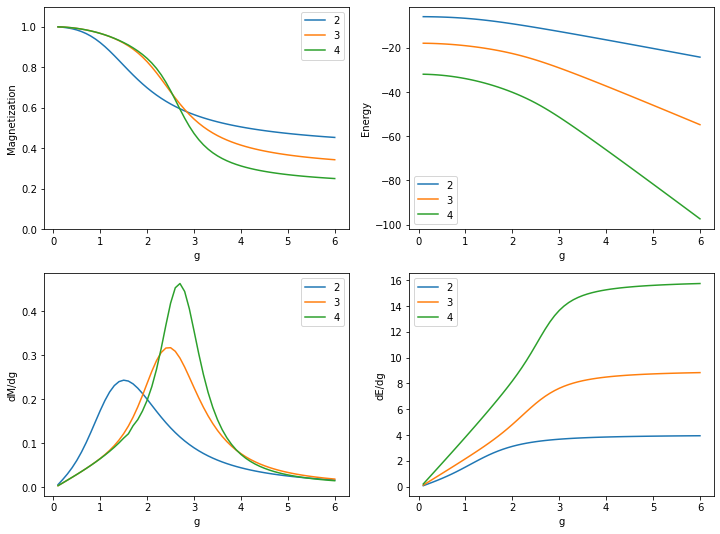

In [7]:
magniz3=magniz
Egs3=Egs
dm3=dm
de3=de
lins3=lins
linell3=linell

plt.figure(figsize=(12, 9))

plt.subplot(221)
for i in range(nell):
    elle=linell3[i]
    plt.plot(lins3[1:],magniz3[1:,i],label=elle)
plt.legend()
plt.ylim(0,1.1)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
for i in range(nell):
    elle=linell3[i]
    plt.plot(lins3[1:],Egs3[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
for i in range(nell):
    elle=linell3[i]
    plt.plot(lins3[1:],dm3[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('dM/dg')

plt.subplot(224)
for i in range(nell):
    elle=linell3[i]
    plt.plot(lins3[1:],de3[1:volte,i],label=elle)
plt.legend()
plt.xlabel('g')
plt.ylabel('dE/dg')
    


plt.show()

Per verificare che il sistema studiato sopra abbia le giuste proprietà di scaling, ovvero quelle di un sistema di Ising 3D classico, procediamo pure in questo caso con uno studio del Finite Size Scaling, utilizzando gli esponenti critici noti in letteratura calcolati in via approssimata, poichè per questo tipo di modello non sono disponibili soluzioni analitiche:

$$\beta=0.326419, \quad \gamma=1.237075, \quad   \nu=0.629971, \quad    Y_g=1.412625$$

sempre considerando il caso con campo esterno longitudinale $h=0$.

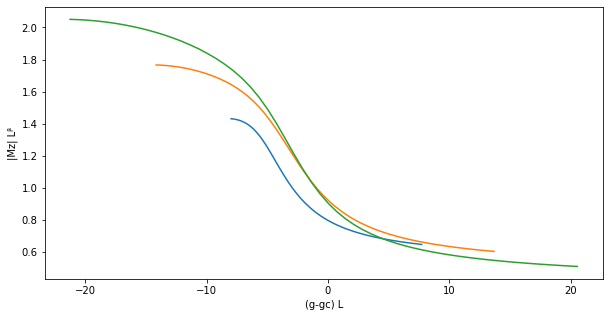

In [23]:
#collapse
Fmagniz=np.zeros((volte,nell))
Flins=np.zeros((volte,nell))

ell1=0
for ell in linell3:

    Fmagniz[:,ell1]=magniz3[:,ell1]*(ell)**(0.326419/0.629971)
    Flins[:,ell1]=(lins3-3.1)*(ell)**1.412625
    
    ell1+=1


plt.figure(figsize=(10,5))

plt.subplot(111)
plt.plot(Flins[1:],Fmagniz[1:])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('|Mz| Lᵝ')



plt.show()

Anche in questo caso possiamo notare che i grafici per le diverse taglie del sistema tendono a sovrapporsi dopo il Finite Size Scaling, anche se non esattamente in questo caso. Probabilmente questo difetto è dovuto alle basse taglie dei sistemi studiati, soprattutto la $2 \times 2$ , ma studiare sistemi $5 \times 5$ o più grandi attraverso diagonalizzazione esatta della matrice hamiltoniana comporterebbe dei tempi di computazione proibitivi.

## Studio di sistemi con connessioni random

Passiamo dunque ora allo studio di un sistema le cui connessioni tra elementi sono rappresentate da una matrice di adiacenza random, ovvero in cui gli elementi della matrice diversi da zero sono disposti in maniera casuale all'interno della matrice stessa. La matrice di adiacenza è data da una funzione delle libreria SciPy che prende in input le dimensioni della matrice e la densità $\rho$ di elementi diversi da zero che si vuole ottenere. Per esempio per un sistema di 10 elementi come quello seguente, prendendo in input i valori (10, 10, 0.2) la funzione rand() restituisce una matrice 10x10 con 20 elementi diversi da zero scelti a caso. 

Poichè per gli stessi valori di input la funzione restituisce realizzazioni diverse di sistemi con le stesse caratteristiche, per avere un comportamento generale verranno calcolate varie realizzazioni di sistemi con gli stessi parametri e i valori di output verranno mediati fra tutte le realizzazioni. Il grafico della media è evidenziato in rosso.

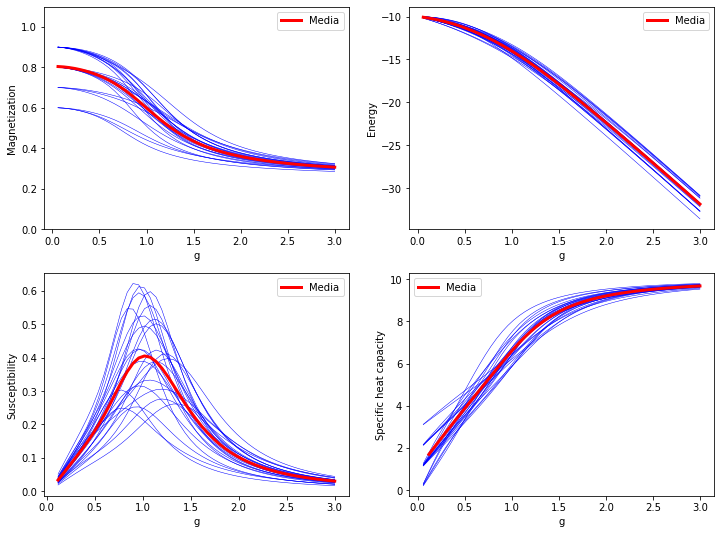

In [39]:
#collapse
hh=0
volte=50
volte+=1

lins=np.linspace(0,3,volte)
linum=np.arange(25)
nell=linum.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))

jay=-1

ell=10
ell1=0
for numer in linum:
    ggg=0
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=ss.rand(ell,ell,0.1)#1/ell)       # Matrice di Adiacenza Random
    coll=ss.find(net)
    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagnetZ=0
        
        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])

        ggg+=1
    ell1+=1


magniz5=magniz
Egs5=Egs
xi5=xi
ci5=ci

plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz5[1:],color="b", linewidth=0.5)
plt.plot(lins[1:],np.mean(magniz5[1:],axis=1),color='r', linewidth=3.0,Label="Media")
plt.legend()
plt.ylim(0,1.1)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs5[1:volte],color="b", linewidth=0.5)
plt.plot(lins[1:],np.mean(Egs5[1:volte],axis=1),color='r', linewidth=3.0,Label="Media")
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[2:],xi5[2:volte],color="b", linewidth=0.5)
plt.plot(lins[2:],np.mean(xi5[2:volte],axis=1),color='r', linewidth=3.0,Label="Media")
plt.legend()
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci5[1:volte],color="b", linewidth=0.5)
plt.plot(lins[2:],np.mean(ci5[2:volte],axis=1),color='r', linewidth=3.0,Label="Media")
plt.legend()
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

Per tutte le realizzazioni si osserva un punto di transizione di fase per valori di $g$ intorno ad 1 con una media poco superiore ad 1. Si può notare inoltre che alcune realizzazioni non producono una magnetizzazione completa nemmeno per $g=0$.


Il sistema precedente, composto da 10 elemtni, aveva come densità di elemeti diversi da zero $\rho=0.1$ . È possibile che il valore del punto di transizione dipenda da questo valore? Per rispondere a questa domanda possiamo procedere con uno studio delle medie di varie realizzazioni con densità variabili da 0.1 a 1, poichè il caso $\rho=0$ è banale e corrisponde ad un sistema senza interazioni e quindi senza magnetizzazione.

In [3]:
#collapse
ell=10    

hh=0
volte=50
volte+=1
nrip=10  

lins=np.linspace(0,5,volte)
linum=np.arange(2,12)*2
nell=linum.size

magnizR=np.zeros((volte,nell,nrip))
EgsR=np.zeros((volte+1,nell,nrip))
xiR=np.zeros((volte+1,nell,nrip))
ciR=np.zeros((volte+1,nell,nrip))

jay=-1


ell1=0
for numer in linum:
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=ss.rand(ell,ell,numer/ell**2)   # Matrice di Adiacenza Random
    coll=ss.find(net)
    
    for rip in range(nrip):
        ggg=0
        for gg in lins:

            # Costruisco la base

            iSpin=np.zeros((NumTot,ell))
            for ii in range(NumTot):
                itemp=ii
                for jj in range(ell):
                    iSpin[ii,jj]=np.floor(itemp%2)
                    itemp=itemp/2


            # Costruisco l'Hamiltoniana

            HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

            for iHam in range(len(coll[2])):
                for ii in range(NumTot):
                    if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                        HamOut[ii,ii]=HamOut[ii,ii] + jay
                    else: HamOut[ii,ii]=HamOut[ii,ii] - jay

            # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

            for iHam in range(ell):
                for ii in range(NumTot):
                    if iSpin[ii,iHam]==1:
                        Exc = ii - 2**(iHam)
                    else: Exc = ii + 2**(iHam)
                    HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

            # Trovo l'autostato del GS

            EgsR[ggg,ell1,rip]=ssl.eigsh(HamOut,1,which='SA')[0]
            Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
            Psii[ggg]=Psi.copy()

            # Calcolo la magnetizzazione

            MagnetZ=0

            for ii in range(NumTot):
                Mag_ii = 0
                for iSite in range(ell):
                    if iSpin[ii,iSite] == 1:
                        Mag_ii = Mag_ii + 1
                    else:
                        Mag_ii = Mag_ii - 1
                MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

            magnizR[ggg,ell1,rip]=MagnetZ/ell
            xiR[ggg,ell1,rip]=-(magnizR[ggg-1,ell1,rip]-magnizR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])
            ciR[ggg,ell1,rip]=-(EgsR[ggg-1,ell1,rip]-EgsR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])

            ggg+=1
    
    magniz7=np.mean(magnizR,axis=2)
    Egs7=np.mean(EgsR,axis=2)
    xi7=np.mean(xiR,axis=2)
    ci7=np.mean(ciR,axis=2)
    
    ell1+=1

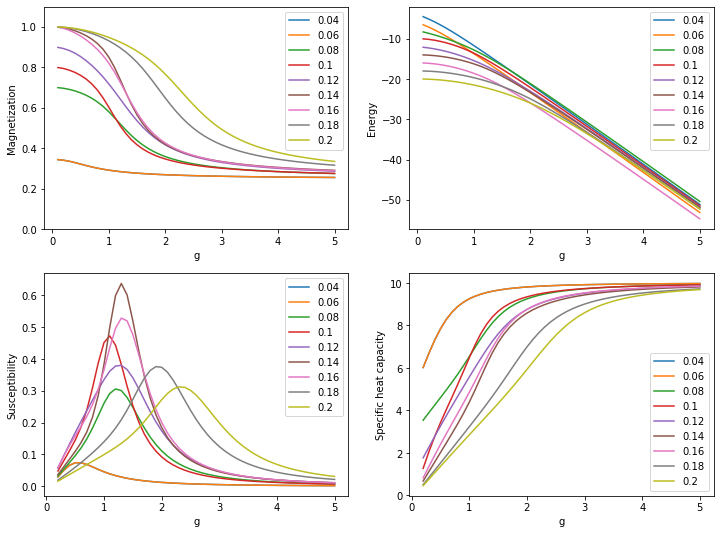

In [4]:
#collapse
plt.figure(figsize=(12, 9))

plt.subplot(221)
for i in range(nell-1):
    plt.plot(lins[1:],magniz7[1:,i],label=round(linum[i]/ell**2,2))
plt.legend()
plt.ylim(0,1.1)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
for i in range(nell-1):
    plt.plot(lins[1:],Egs7[1:volte,i],label=round(linum[i]/ell**2,2))
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
for i in range(nell-1):
    plt.plot(lins[2:],xi7[2:volte,i],label=round(linum[i]/ell**2,2))
plt.legend()
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
for i in range(nell-1):
    plt.plot(lins[2:],ci7[2:volte,i],label=round(linum[i]/ell**2,2))
plt.legend()
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

Dal grafico sopra possiamo notare due cose:

1. a valori di $\rho$ maggiori corrispondono punti di transizione a valori di $g$ maggiori
2. esiste un valore di $\rho$ sotto il quale il sistema non raggiunge la magnetizzazione totale nemmeno per $g=0$

Per studiare meglio il secondo effetto verranno calcolate di seguito le medie di 100 realizzazioni di sistemi con $g=0$ andando a vedere l'andamento per valori crescenti di $\rho$ , più precisamente, considerando un sistema composto da 8 elementi, studiando l'andamento al variare del numero di elementi della matrice di adiacenza diversi da zero.

In [15]:
# collapse
ell=8    

hh=0
gg=0


nrip=100  

linum=np.arange(1,21)
nell=linum.size

magnizR=np.zeros((nell,nrip))
EgsR=np.zeros((nell,nrip))
xiR=np.zeros((nell,nrip))
ciR=np.zeros((nell,nrip))

jay=-1

NumTot=2**ell


ell1=0
for numer in linum:
    ev=np.zeros((NumTot))
    Psii=np.zeros((NumTot))
    
    net=ss.rand(ell,ell,numer/ell**2)   # Matrice di Adiacenza Random
    coll=ss.find(net)
    
    for rip in range(nrip):
        
        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]
        
        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        EgsR[ell1,rip]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]

        # Calcolo la magnetizzazione

        MagnetZ=0

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magnizR[ell1,rip]=MagnetZ/ell
       # xiR[ell1,rip]=-(magnizR[ggg-1,ell1-1,rip]-magnizR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])
       # ciR[ell1,rip]=-(EgsR[ggg-1,ell1,rip]-EgsR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])

    
    magniz8=np.mean(magnizR,axis=1)
    Egs8=np.mean(EgsR,axis=1)
   # xi8=np.mean(xiR,axis=1)
   # ci8=np.mean(ciR,axis=1)
    
    ell1+=1

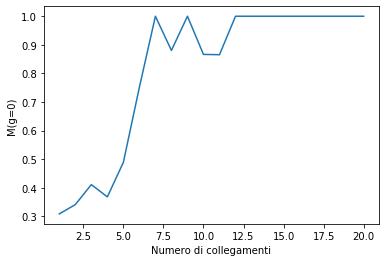

In [18]:
#collapse
plt.plot(linum,magniz8)
plt.ylabel('M(g=0)')
plt.xlabel('Numero di collegamenti')
plt.show()

Nelle ascisse sebbene siano rappresentati anche valori decimali, i valori considerati sono solo numeri interi che vanno da 1 a 20. Possiamo notare una sorta di transizione di fase, anche se non lo è propriamente: la magnetizzazione infatti cresce fino ad arrivare alla saturazione per valori intorno ad 8, ovvero il numero di elementi del sistema.

Questo dimostra un fenomeno abbastanza intuitivo ovvero, la magnetizzazione completa si può ottenere solamente se ogni elemento interagisce con almeno un altro elemento del sistema e questo può accadere solo se il numero di collegamenti è almeno pari al numero degli elementi. Questa condizione è solo necessaria in quanto, come possiamo notare dal grafico con la media di varie realizzazioni, che hanno la stessa densità pari a 0.1, quindi 10 elementi di matrice di adiacenza diversi da zero, ci sono alcune realizzazioni che per $g=0$ non hanno $M=1$ ma inferiore, segno che alcuni collegamenti sono stati fatti tra elementi già collegati e quindi altri elementi sono rimasti isolati.

Per quanto riguarda il primo punto invece, possiamo notare dai grafici precedenti che all'aumentare della densità di elementi diversi da zero, e quindi del numero di connessioni a lungo raggio, il punto di transizione avviene per valori di $g$ sempre maggiori, risultato verosimile in quanto più connessioni ferromagnetiche ci sono più è probabile che il sistema presenti una fase ferromagnetica più stabile all'aumentare di $g$, che tende a distruggere la magnetizzazione del sistema. 

Si può osservare che anche per $\rho = 1$ esiste un valore di $g$ per cui si ha una transizione di fase e sopra il quale si ha una fase paramagnetica. Ciò è in qualche maniera sorprendente perchè per $\rho = 1$ si ha una matrice di adiacenza piena alla quale corrisponde un network con connessioni all-to-all, quindi ogni elemento del sistema tende ad allinearsi con ogni altro elemento del sistema, formando una fase ferromagnetica particolarmente forte, come si può notare dal plateau iniziale nella magnetizzazione, ma comunque non "indistruttibile".

Può essere interessante andare a studiare come il punto di transizione di un network all-to-all dipenda dalla taglia del sistema.

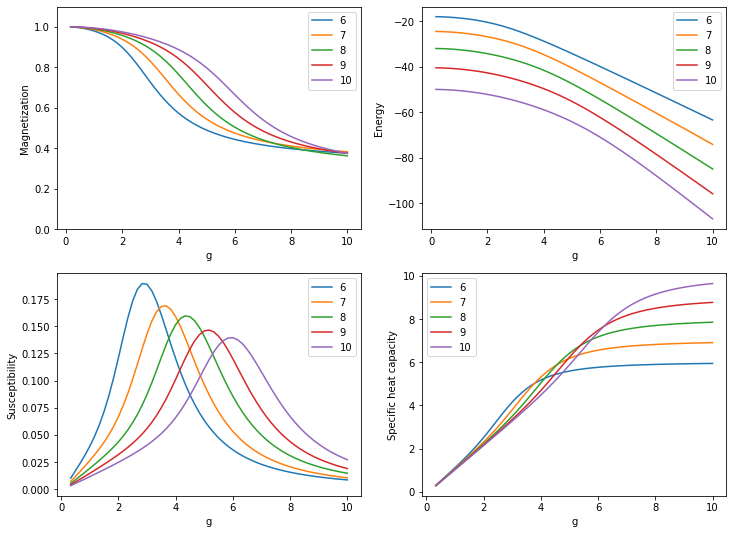

In [39]:
#collapse

hh=0
volte=60
volte+=1
nrip=1   #

lins=np.linspace(0,10,volte)
linell=np.arange(6,11)
nell=linum.size

magnizR=np.zeros((volte,nell,nrip))
EgsR=np.zeros((volte+1,nell,nrip))
xiR=np.zeros((volte+1,nell,nrip))
ciR=np.zeros((volte+1,nell,nrip))

jay=-1/2


ell1=0
for ell in linell:
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=ss.rand(ell,ell,1)   # Matrice di Adiacenza All-to-All
    coll=ss.find(net)
    
    for rip in range(nrip):
        ggg=0
        for gg in lins:

            # Costruisco la base

            iSpin=np.zeros((NumTot,ell))
            for ii in range(NumTot):
                itemp=ii
                for jj in range(ell):
                    iSpin[ii,jj]=np.floor(itemp%2)
                    itemp=itemp/2


            # Costruisco l'Hamiltoniana

            HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

            for iHam in range(len(coll[2])):
                for ii in range(NumTot):
                    if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                        HamOut[ii,ii]=HamOut[ii,ii] + jay
                    else: HamOut[ii,ii]=HamOut[ii,ii] - jay

            # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

            for iHam in range(ell):
                for ii in range(NumTot):
                    if iSpin[ii,iHam]==1:
                        Exc = ii - 2**(iHam)
                    else: Exc = ii + 2**(iHam)
                    HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

            # Trovo l'autostato del GS

            EgsR[ggg,ell1,rip]=ssl.eigsh(HamOut,1,which='SA')[0]
            Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
            Psii[ggg]=Psi.copy()

            # Calcolo la magnetizzazione

            MagnetZ=0

            for ii in range(NumTot):
                Mag_ii = 0
                for iSite in range(ell):
                    if iSpin[ii,iSite] == 1:
                        Mag_ii = Mag_ii + 1
                    else:
                        Mag_ii = Mag_ii - 1
                MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

            magnizR[ggg,ell1,rip]=MagnetZ/ell
            xiR[ggg,ell1,rip]=-(magnizR[ggg-1,ell1,rip]-magnizR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])
            ciR[ggg,ell1,rip]=-(EgsR[ggg-1,ell1,rip]-EgsR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])

            ggg+=1
    
    magniz6=np.mean(magnizR,axis=2)
    Egs6=np.mean(EgsR,axis=2)
    xi6=np.mean(xiR,axis=2)
    ci6=np.mean(ciR,axis=2)
    
    ell1+=1


plt.figure(figsize=(12, 9))

plt.subplot(221)
for i in linell:
    plt.plot(lins[1:],magniz6[1:,i-linell[0]],label=i)
plt.legend()
plt.ylim(0,1.1)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
for i in linell:
    plt.plot(lins[1:],Egs6[1:volte,i-linell[0]],label=i)
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
for i in linell:
    plt.plot(lins[2:],xi6[2:volte,i-linell[0]],label=i)
plt.legend()
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
for i in linell:
    plt.plot(lins[2:],ci6[2:volte,i-linell[0]],label=i)
plt.legend()
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

Possiamo notare dai grafici sopra che il valore di $g$ corrispondente al punto di critico aumenta con l'aumentare della taglia. È legittimo dunque pensare che nel limite termodinamico il valore di $g$ alla transizione di fase diverga e dunque che un sistema con connessioni ferromagnetiche all-to-all rimanga magnetizzazato per qualunque valore di $g$.